# Project 1 - Sentiment Classification 

Group 22
Group Members:  CAI, Shizhan  CHEN, Zixin  LIANG Haoran ZHANG Weiwen



#####  This is the code for our best model (BERT) and we choose it as our final code. If you want to check the codes for all other models we tried, please see the folder 'Supplementary'.





## 1. Load the data

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

%cd /content/drive/MyDrive/comp4332-project1-cnn-trial

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/comp4332-project1-cnn-trial


In [2]:
# import all libraries required

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pip install transformers

In [4]:
############ Try Bert

import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score

import random

In [5]:
def load_data(split_name='train', columns=['text', 'stars']):
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        df = df.loc[:,columns]
        print("succeed!")
        return df
    except:
        print("Failed, then try to ")
        print(f"select all columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        return df

In [6]:
# Extract all the datum 

train_df = load_data('train')
valid_df = load_data('valid')
test_df = load_data('test')

train_df_full = load_data('train', columns='full')
val_df_full = load_data('valid', columns='full')
test_df_full = load_data('test', columns='full')

select [text, stars] columns from the train split
succeed!
select [text, stars] columns from the valid split
succeed!
select [text, stars] columns from the test split
Failed, then try to 
select all columns from the test split
select [f, u, l, l] columns from the train split
Failed, then try to 
select all columns from the train split
select [f, u, l, l] columns from the valid split
Failed, then try to 
select all columns from the valid split
select [f, u, l, l] columns from the test split
Failed, then try to 
select all columns from the test split


In [7]:
train_df.head()

,text,stars
0,Nice to have a diner still around. Food was go...,4
1,"Tried this a while back, got the fried chicken...",2
2,I expected more pork selections on menu. Food ...,4
3,YUMMY!!! This place is phenomenal. It is Price...,4
4,The Truffle Macaroni & Cheese and Potatoes Au ...,5


## 2. Preprocessing



#### Explorative data analysis



Explore the relationship between different features

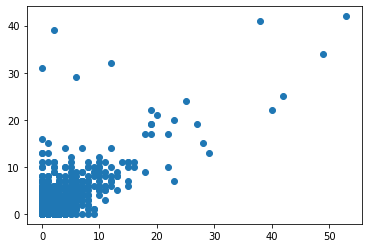

In [8]:
# check the relationship between cool & funny
plt.scatter(train_df_full['cool'], train_df_full['funny'])

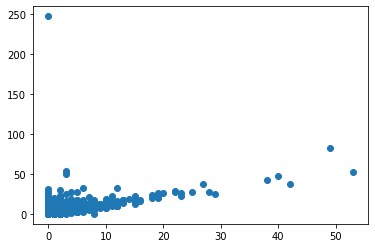

In [9]:
# check the relationship between useful and cool
plt.scatter(train_df_full['cool'], train_df_full['useful'])

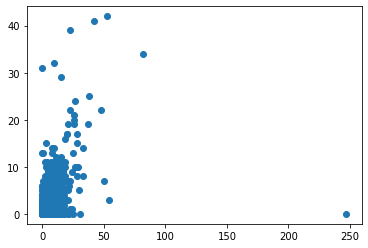

In [10]:
# check the relationship between useful and funny
plt.scatter(train_df_full['useful'], train_df_full['funny'])

In [11]:
# check the distribution based on 'useful'
# since the majority of reviews get 0 in 'useful', we don't do any modification
train_df_full['useful'].describe()

count    10000.000000
mean         1.466100
std          3.914075
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        247.000000
Name: useful, dtype: float64

## 3. Models


### BERT (Best model)

In [12]:
train_bert_df = train_df
valid_bert_df = valid_df
test_bert_df = test_df

In [13]:
for i in range(len(train_bert_df)):
    train_bert_df['stars'][i] = train_bert_df['stars'][i] -1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
for i in range(len(valid_bert_df)):
    valid_bert_df['stars'][i] = valid_bert_df['stars'][i] -1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)
                                          


In [16]:
encoded_data_train = tokenizer.batch_encode_plus(
    train_bert_df['text'], 
    add_special_tokens=True,  # the sequences will be encoded with the special tokens relative to our model
    return_attention_mask=True, # return the attention mask according to the specific tokenizer defined by the max_length
    pad_to_max_length=True, 
    # padding=True,
    # truncation=True,
    max_length=512,  # 512 is the maximum for bert model
    return_tensors='pt' # to return PyTorch
)

encoded_data_val = tokenizer.batch_encode_plus(
    valid_bert_df['text'], 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    # padding=True,
    # truncation=True,
    max_length = 512, 
    return_tensors='pt'
)

encoded_data_test = tokenizer.batch_encode_plus(
    test_bert_df['text'], 
    add_special_tokens=True, 
    return_attention_mask=True, 
    pad_to_max_length=True, 
    # padding=True,
    # truncation=True,
    max_length=512, 
    return_tensors='pt'
)




input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_bert_df['stars'])

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(valid_bert_df['stars'])

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']


dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)
dataset_test = TensorDataset(input_ids_test, attention_masks_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2074: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [17]:
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=5,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [18]:
batch_size = 16

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)
# DataLoader combines a dataset and a sampler, and provides an iterable over the given dataset

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)
dataloader_test = DataLoader(dataset_test, 
                                   sampler=SequentialSampler(dataset_test), 
                                   batch_size=batch_size)

In [35]:
optimizer = AdamW(bert_model.parameters(),
                  lr=3e-5, 
                  eps=1e-8)
                  
epochs = 5

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)
# Create a schedule with a learning rate that decreases linearly from the initial learning rate set in the optimizer to 0,
#  after a warmup period during which it increases linearly from 0 to the initial learning rate set in the optimizer.

In [20]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [36]:
seed_val = 20
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    bert_model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = bert_model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

f1_scores = []
training_loss = []
validation_loss = []    
for epoch in tqdm(range(1, epochs+1)):
    
    bert_model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        bert_model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        bert_model = bert_model.to(device)
        outputs = bert_model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    torch.save(bert_model.state_dict(), f'./finetuned_BERT_epoch_{epoch}.bert_model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')
    f1_scores.append(val_f1)
    validation_loss.append(val_loss)
    training_loss.append(loss_train_avg)




Epoch 1
Training loss: 0.5105943194270134
Validation loss: 0.9834736816883087
F1 Score (Weighted): 0.6331391244178494



Epoch 2
Training loss: 0.35834048172831534
Validation loss: 1.0002143280506135
F1 Score (Weighted): 0.6486400881929935



Epoch 3
Training loss: 0.26049204528927805
Validation loss: 1.236693154335022
F1 Score (Weighted): 0.6534134553364728



Epoch 4
Training loss: 0.13378680044412614
Validation loss: 1.6323046503067016
F1 Score (Weighted): 0.6540191084739394



Epoch 5
Training loss: 0.06367156109847129
Validation loss: 1.8860850954055786
F1 Score (Weighted): 0.6539081993511408



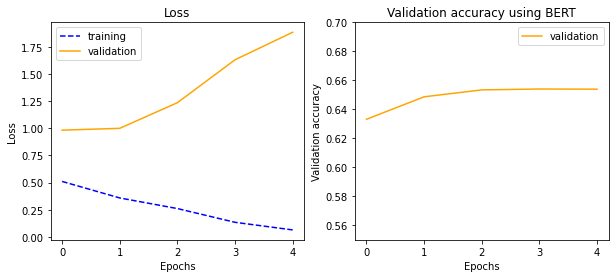

In [37]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(training_loss, label="training", color="blue", linestyle="dashed")
plt.plot(validation_loss, label="validation", color="orange")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(f1_scores, label="validation", color="orange")
plt.ylim(0.55, 0.7)
plt.title("Validation accuracy using BERT") 
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")
plt.legend()
plt.show()

In [ ]:
def predict(dataloader_test):

    bert_model.eval()
    
    loss_test_total = 0
    predictions = []
    
    for batch in dataloader_test:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                 }

        with torch.no_grad():        
            outputs = bert_model(**inputs)
            # print(outputs)
            
        
        logits = outputs[0]
        

        logits = logits.detach().cpu().numpy()
        predictions.append(logits)
    
    
    
    predictions = np.concatenate(predictions, axis=0)
            
    return predictions

In [ ]:
test_predictions= predict(dataloader_test)

In [ ]:
test_predictions

In [ ]:
# reserve the testing result
list_test_pre = test_predictions.tolist()
test_pre_vals = []

for i in range(len(list_test_pre)):
    test_pre_vals.append(list_test_pre[i].index(max(list_test_pre[i])))

In [ ]:
final_test_ans = []

for i in range(len(test_pre_vals)):
  final_test_ans.append(test_pre_vals[i]+1)

In [ ]:
final_test_ans[-5:]

In [ ]:
test_ans = pd.DataFrame(data={
    'review_id': test_df['review_id'],
    'stars': final_test_ans
})

In [ ]:
test_ans

In [ ]:
# test_pre_vals
test_ans.to_csv(f'group22-0.672test_ans.csv', index=False)